In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [3]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [4]:
# Load the training data
atlanta_file_path = '../../Data/Clean/combined/Atlanta_combined.csv'
train_full_df = pd.read_csv(atlanta_file_path)
train_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [5]:
# Remove columns that are too predictive
cols_to_remove = ['HomeValueIndexSmSa', 'HomeValueIndex']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)

## Create an EdaToolbox object

In [7]:
# Initialize the EdaToolbox
target_col = 'MeanSalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [8]:
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"ATLANTA, GA",1,0,0.0,"Index(['ATLANTA, GA'], dtype='object', name='C..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,4414.04779,1,0,0.0,"Index([4414.04779], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,89.810682,1,0,0.0,"Index([89.810682], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,41.859123,1,0,0.0,"Index([41.859123], dtype='float64', name='PctB..."


In [9]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## First check the distribution of the target column and select an appropriate target column transformer

In [10]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}

In [11]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}


In [12]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [14]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.116371,0.117442,1.000480,0.665518,0.167873,0.174776,0.116233,0.067280
PowerTransformer,0.000015,0.000016,0.000213,0.000213,0.000015,0.000015,0.000015,0.000016
QuantileTransformer,0.354736,0.321640,1.069903,0.748725,0.331021,0.328537,0.323215,0.351611


Note for Atlanta dataset
* The PowerTransformer combined with Linear Regression, LassoCV, or RidgeCV provided the best results
* Excellent performance on data (maybe too good?)

In [15]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.156810,0.157714,0.962408,0.638098,0.168201,0.166934,0.158803,0.053553
PowerTransformer,0.000016,0.000016,0.000200,0.000200,0.000015,0.000015,0.000016,0.000013
QuantileTransformer,0.298056,0.191581,0.864379,0.561032,0.141927,0.164375,0.191581,0.176112


Note for Atlanta dataset
* HistGradientBoost combined with PowerTransformer preprocessing

In [16]:
# Use basic OHE feature transformer
eda.feature_transformer = eda.get_basic_ohe_feature_transformer()

In [17]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.141163,0.145738,1.000480,0.716897,0.146032,0.146454,0.142619,0.115391
PowerTransformer,0.000045,0.000046,0.000213,0.000213,0.000048,0.000048,0.000046,0.000029
QuantileTransformer,0.455997,0.454298,1.100114,0.831416,0.479494,0.475035,0.456378,0.395551


Note for Atlanta dataset
* PowerTransformer has slightly higher RMSE in Linear and Ridge Regression, Lasso regression still the better result even though slightly higher
* HistGradientBoost with the best result

In [18]:
# Evaluate RMSE for various regression models and target transformations with all ordinally encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_dfS

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.194380,0.203400,0.962408,0.673315,0.213381,0.213231,0.200655,0.094653
PowerTransformer,0.000044,0.000049,0.000200,0.000200,0.000048,0.000048,0.000048,0.000021
QuantileTransformer,0.325178,0.365495,0.932047,0.632029,0.409137,0.404607,0.375894,0.205191


Note:
* HistGradientBoost still has the best result, made even better than the last

## Set the target and feature column tranformers

* Use the PowerTransformer for the target column
* Use the basic ordinal feature transformer

In [19]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good RMSE scores with very basic encoding and no feature selection
eda.target_transformer = PowerTransformer(standardize=False)
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [20]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"ATLANTA, GA",1,0,0.0,"Index(['ATLANTA, GA'], dtype='object', name='C..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,4414.04779,1,0,0.0,"Index([4414.04779], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,89.810682,1,0,0.0,"Index([89.810682], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,41.859123,1,0,0.0,"Index([41.859123], dtype='float64', name='PctB..."


In [21]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [22]:
# Frist check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 0.01 (R^2 score:  1.00)


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.995576,0.000207,0.781414,29.616462,0.113612,0.117344,1.226739
numerical__NUM_JOBS,0.931191,0.000002,0.864894,12.121423,0.094632,0.146185,1.172009
numerical__TotalTransactionValue,0.875734,0.000006,0.615835,35.487244,0.215989,0.008053,1.099782
numerical__SalesCount,0.524741,0.000003,0.759130,8.067187,0.156631,0.223679,0.905054
numerical__NewConstructMeanSalePrice,0.296968,0.000003,0.929732,18.044360,0.165815,0.384977,0.847763


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


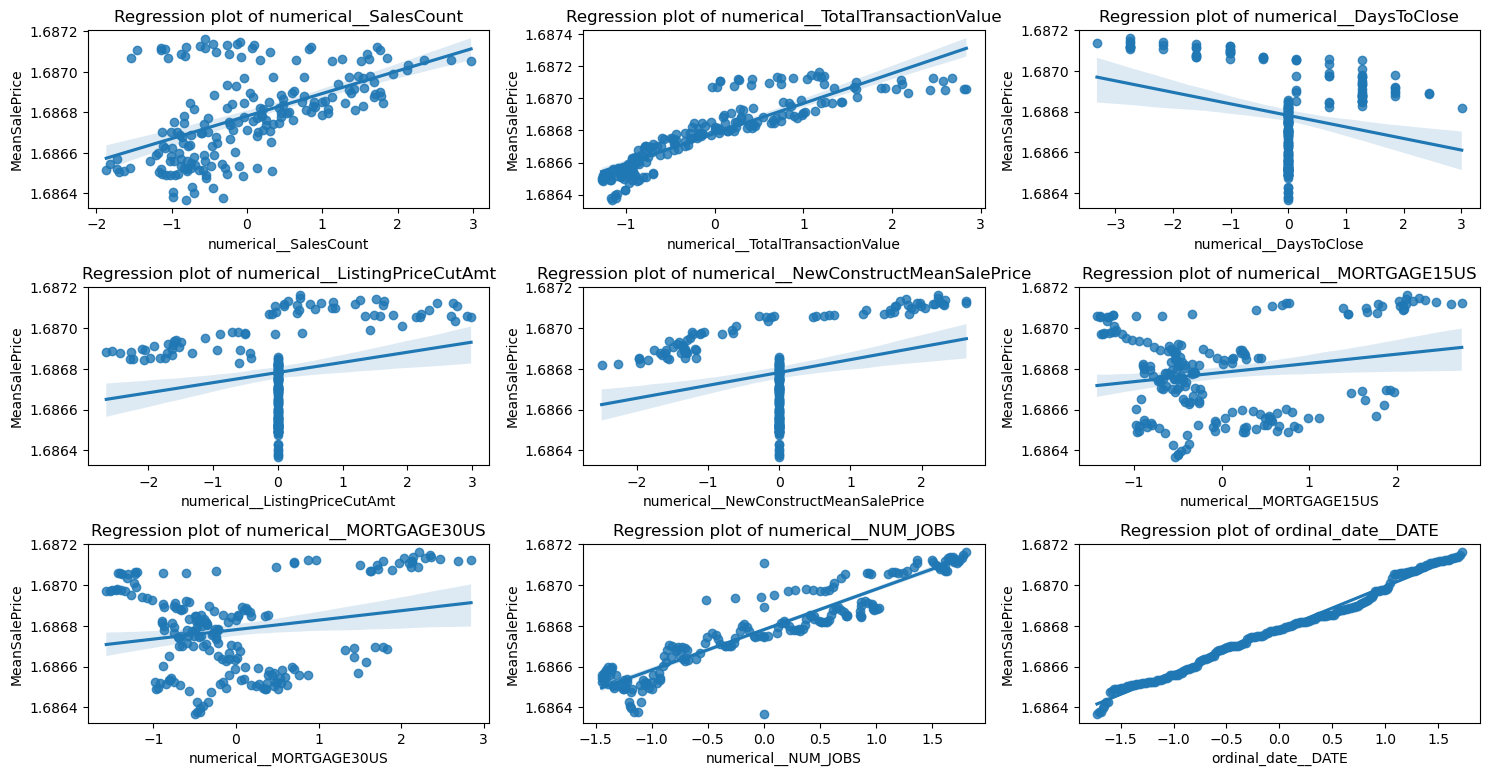

In [26]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.2)

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


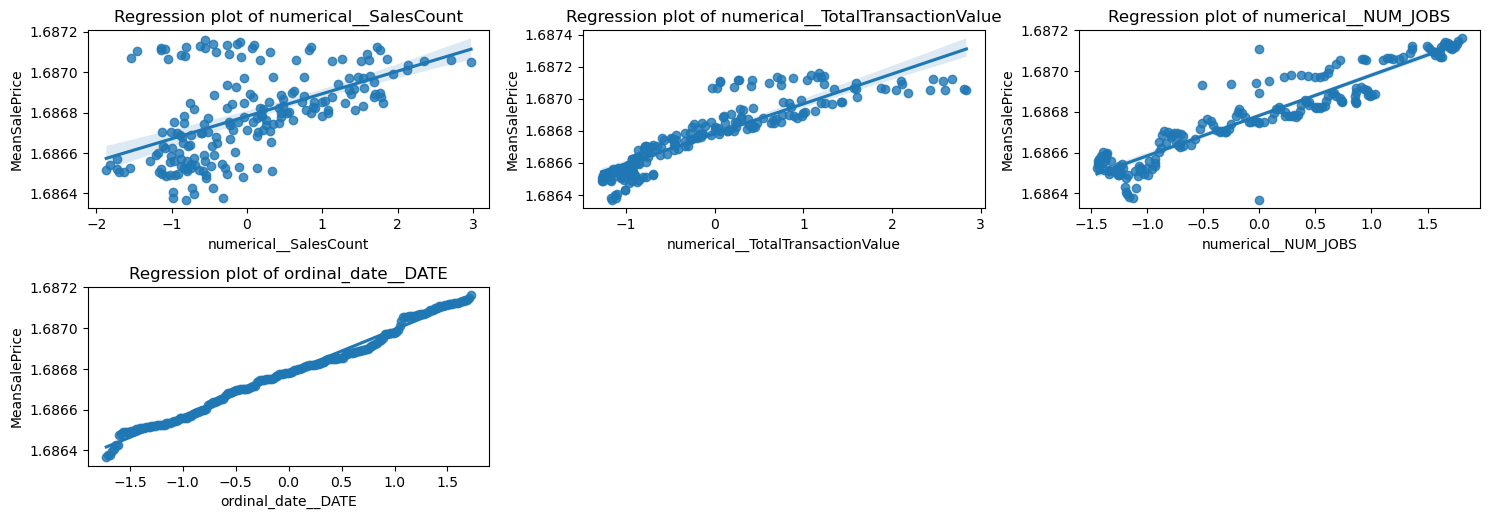

In [25]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.5)

## Perform unsupervised feature selection

Optimal number of features: 7


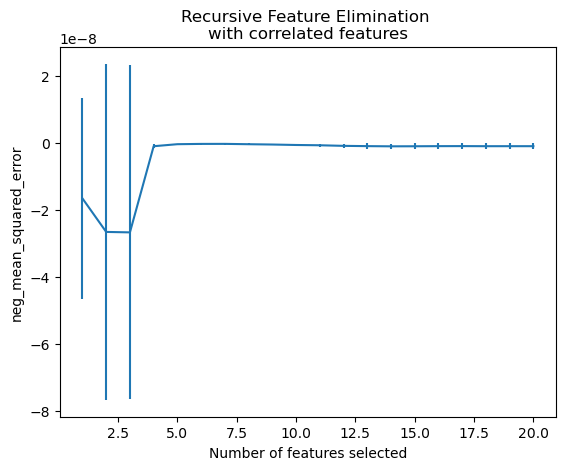

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-1.663082e-08,2.999597e-08,-3.701341e-10,-7.659989e-08,-2.891444e-09,-1.292773e-09,-1.999845e-09,False,5,SalesCount
1,-2.661076e-08,5.007970e-08,-3.067917e-10,-1.267576e-07,-2.728451e-09,-1.317532e-09,-1.943398e-09,False,4,TotalTransactionValue
2,-2.674618e-08,4.981334e-08,-1.944223e-09,-1.263674e-07,-2.751227e-09,-1.316070e-09,-1.351939e-09,False,10,MarketTempIdx
3,-1.062756e-09,6.351160e-10,-1.942595e-09,-5.739104e-10,-1.361070e-10,-1.302006e-09,-1.359162e-09,False,7,DaysToClose
4,-4.596388e-10,1.759267e-10,-6.661124e-10,-4.907108e-10,-1.333002e-10,-5.229469e-10,-4.851239e-10,True,1,DaysOnZillow


In [27]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [28]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['DaysOnZillow' 'SaleToList' 'PctSoldAboveList' 'MORTGAGE15US'
 'MORTGAGE30US' 'RATE_DIFFERENCE' 'DATE']


Optimal number of features: 4


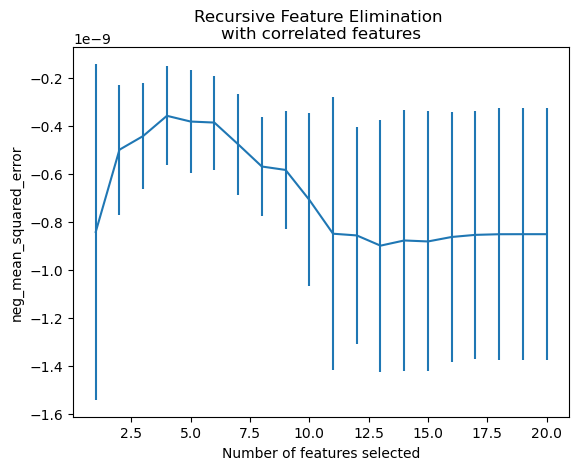

In [29]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=7))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [30]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['ListingPriceCutPct' 'SaleToList' 'PctSoldBelowList' 'DATE']


In [38]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 10 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=10)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 0.001
Selected 10 features by forward sequential featureselection in 1.082 seconds
SFS Ridge Selected Features: ['SalesCount', 'MarketTempIdx', 'DaysOnZillow', 'ListingPriceCutAmt', 'ListingPriceCutPct', 'NewConstructSalesCount', 'PctListingsPriceCut', 'MORTGAGE30US', 'DATE', 'CityName']


In [39]:
# # Remove colinear features from the list of selected features
# # rfe_ridge_selected_features = [rfe_ridge_selected_features]
# rfe_ridge_selected_features = list(rfe_ridge_selected_features).remove('PctListingsPriceCut')
# rfe_ridge_selected_features

In [40]:
# Update EDA object with selected features from RFE
eda.selected_feature_list = rfe_ridge_selected_features

# Now get the list of selected ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(rfe_lr_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(1, ['DATE'])

## Perform final EDA with selected features and ordinal columns

In [41]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=['ListingPriceCutPct',
                                                                                                     'SaleToList',
                                                                                                     'PctSoldBelowList',
                                                                                                     'DATE'])),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['SalesCount', 'TotalTransact...
                                                                              '2011-03-31',
                                                                              '2012-10-31',
                                                                              '2009-04-30',
                                                                              '2010-11-30',
                                                                              '2011-02-28',
                                                                              '2010-12-31',
                                                                              '2009-02-28',
                                                                              '2011-05-31',
                                                                              '2012-06-30',
                                                                              '2012-09-30',
                                                                              '2010-10-31',
                                                                              '2011-01-31',
                                                                              '2009-05-31',
                                                                              '2009-01-31',
                                                                              '2013-01-31',
                                                                              '2011-08-31',
                                                                              '2012-12-31',
                                                                              '2010-03-31', ...]],
                                                                 encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['DATE'])])

In [42]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 0.01 (R^2 score:  1.00)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.995576,0.000209,0.000024,1.042382,0.121019,0.992340,2.109145
numerical__PctSoldBelowList,0.199702,0.000027,0.530972,24.185753,0.582528,0.054267,0.836525
numerical__SaleToList,0.158046,0.000027,0.550780,20.135578,0.576642,0.088756,0.823471
numerical__ListingPriceCutPct,0.185083,0.000011,0.889811,4.942395,0.559910,0.066618,0.811622


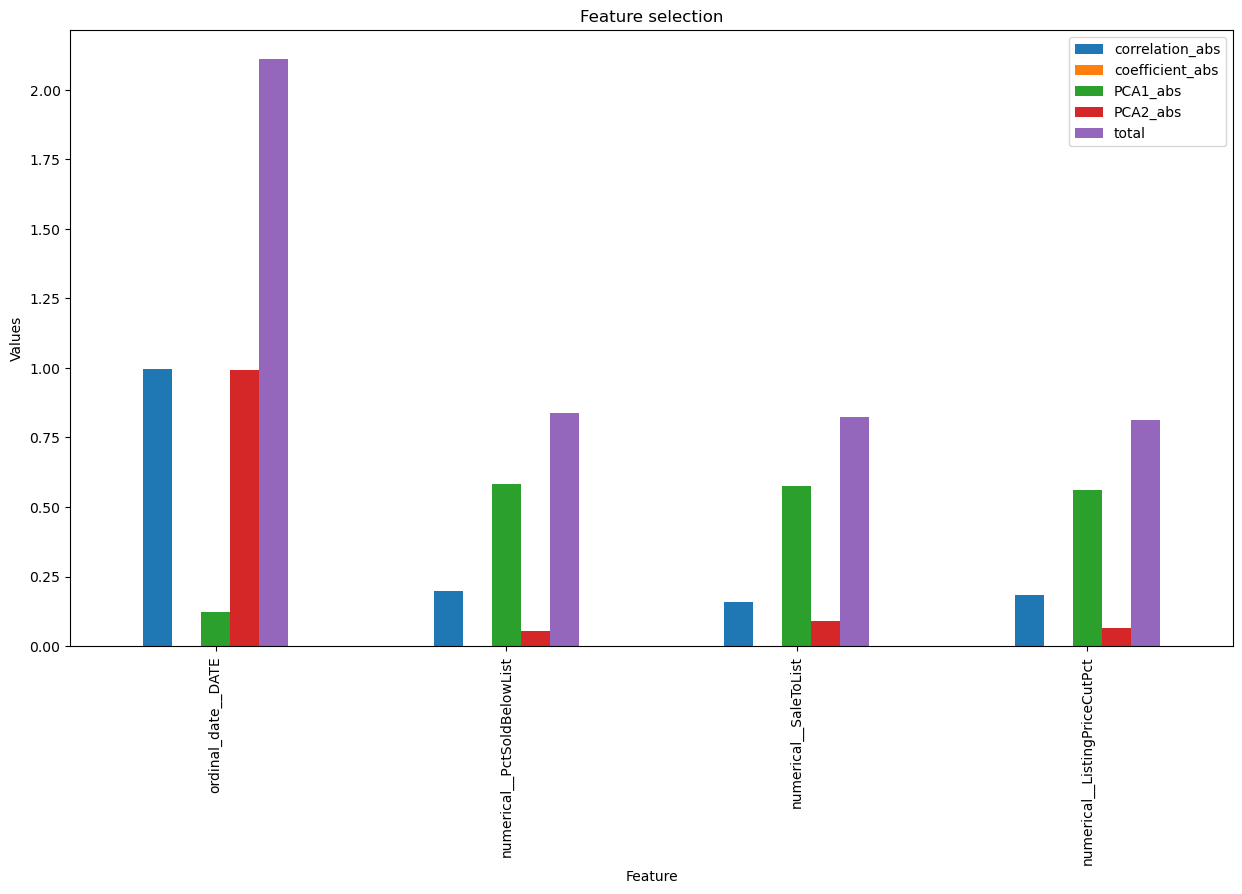

In [43]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [45]:
# Reload the data just to be safe
train_full_df = pd.read_csv(atlanta_file_path)

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column=target_col)
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [46]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [47]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 25
Number scaled X cols: 4


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time,y_pred
model_name,,,,,,,,
Ridge Regression,0.995569,2.620043e-10,0.993451,0.992681,0.992034,0.004246,0.008909,"[1.6868744611106725, 1.6866165113948137, 1.687..."
LassoCV,0.995538,2.622438e-10,0.993445,0.992674,0.992034,0.004246,0.039037,"[1.686876984897431, 1.6866155419973623, 1.6870..."
ElasticNetCV,0.995538,2.622438e-10,0.993445,0.992674,0.992034,0.004246,0.036023,"[1.6868769849030503, 1.6866155420292879, 1.687..."
RidgeCV,0.995635,2.645672e-10,0.993387,0.992609,0.992034,0.004246,0.006580,"[1.6868738326345065, 1.6866156329507758, 1.687..."
Linear Regression,0.995635,2.646390e-10,0.993386,0.992607,0.992034,0.004246,0.010015,"[1.6868738224308388, 1.6866156244393784, 1.687..."
HistGradientBoost,0.993618,3.443468e-10,0.991393,0.990381,0.992034,0.004246,0.178380,"[1.6868761558722476, 1.6866016166214561, 1.686..."


* Ridge CV has the highest r2 and adjusted r2 values and therefore the optimal choice

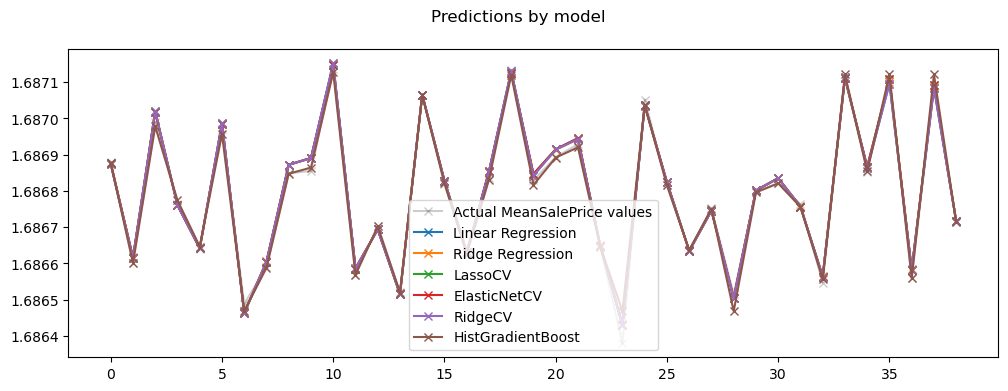

In [48]:
reg.plot_model_evaluations()

* Looks overfit to me

In [49]:
# Get the best model
reg.best_model_name

'Ridge Regression'

## Now use the best model to predict on the test data

In [56]:
# Load test data from a different city
combined_file_path = '../../tw/combined_cities.csv'
test_full_df = pd.read_csv(combined_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [67]:
# Drop target column
combined_file_df = test_full_df[target_col]
test_full_df = test_full_df.drop([target_col])
test_full_df.head()

KeyError: 'MeanSalePrice'

In [52]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([196606.75008567, 199628.83459339, 201684.87637794, 200652.66189617,
       198613.30124795, 191729.23822738, 186125.99765161, 178196.75506636,
       174843.94760544, 162387.25676913, 157376.17426905, 151286.45251209,
       154622.31205013, 161655.94872807, 175672.67480683, 181653.12194711,
       184316.01967694, 179911.72165015, 177349.01277639, 176507.67475473,
       173205.05438723, 170792.17534001, 166887.89797862, 165365.84205734,
       172394.7619298 , 179050.96870049, 182533.90984736, 183421.51819959,
       180779.08279687, 174021.4286768 , 160208.97338809, 155303.5431149 ,
       156680.42756807, 160929.87133251, 155989.5661641 , 153274.0432015 ,
       151944.39977619, 158076.85378968, 169213.1825001 , 169999.75961204,
       163865.77279975, 149984.0913178 , 149339.59270538, 148063.75151315,
       147432.32723577, 146805.18017669, 145563.55956816, 146182.27068307,
       148699.49313454, 150633.03055772, 158782.51424193, 167657.30942395,
       166124.09416407, 1

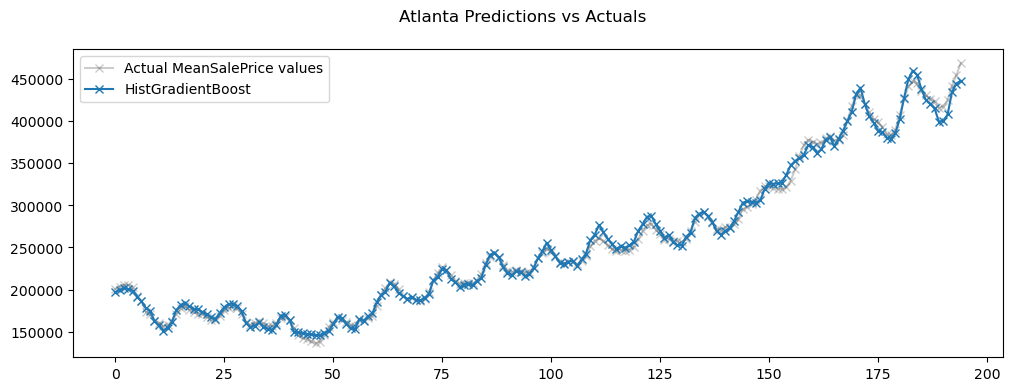

In [53]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()